# Background

We measured aesthetic preferences with a two-alternative forced choice task (2-AFC).  On each trial, subjects saw two images and asked to select the one they preferred with a keypress.  To ensure that subjects were paying attention, we randomly included trials in which the subject had to select the larger number between two images of numbers. 

This task was completed on six separate occasions.  For ease of reference, we refer to each of these occasions numerically by session.  Each session was one week apart, except for Session 1, which consisted of two separate 2-AFC tasks, roughly 20 minutes apart, referred to as Session 1A and Session 1B respectively.

In Session 1A, after providing consent and debriefing, participants began by completing a 2-AFC task on images of cars, shirts, and phone cases in three separate blocks, one for each category of objects.  The order of these blocks was counter-balanced across subjects.  Each block consisted of a total of 105 unique comparisons, presented in random order.  After completing all 3 blocks, subjects were given a digit-span memory task lasting roughly 20 minutes.  Immediately after, in Session 1B, participants again completed the same 2-AFC preference task as before.  Therefore, the first two preference measurements were 20 minutes apart.  The digit span task was given in between in order mitigate any short-term memory effects.  In addition, participants were given explicit instructions to complete all preference tasks based on their preference at that very moment, and not based on memory of previous choices.  After completing both parts of the first session, participants were required to return on a weekly interval for 4 weeks.  At each following session, participants were administered the same 2-AFC preference task, with the same procedure as Session 1B.

Session 6: Association Valence and Psychological Surveys
One week after completion of Sessions 1 - 5, participants were asked to return for a final follow up aesthetic-preference session.  Here, participants completed a Unique Corporate Association Valence  task (Spears et al., 2006; Schepman et al., 2015).  In this task, participants received the following instructions: 
“Please write a word or short description in the boxes below of any thoughts that the image brings to mind.  Please try not to use colors in the descriptions. Type your responses in the three boxes and then please indicate how positive, neutral, or negative the description is to you.” 

In response, participants provided three associations for each object.  Then, participants rated each of the associations on a subjective valence scale ranging from -3 to +3.  This association task was only conducted with images of cars and shirts due to time limitations. 

After completing the valence association tasks, participants filled out three psychological surveys.  They were the Barrat Impulsivity Test (Stanford et al., 2009), the revised Green et al., Paranoid Thoughts Scale (Freeman et al., 2021), and the General Anxiety Disorder-7 Questionnaire (Spitzer et al., 2006). To ensure that subjects were paying attention, each of the surveys included mock questions that required subjects to click a predefined option.




# Aim 

To develop a statistical test for understanding whether differenecs in a binary comparison matrix over time are statistically real, or due to chance

# Dependencies

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from math import pi
from itertools import combinations_with_replacement
import pickle
from IPython.display import display
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
from natsort import natsorted
import seaborn as sns
import scipy.stats as stats 
from collections import Counter
from itertools import groupby
from operator import itemgetter
from itertools import combinations
import time
import datetime
import choix
import plotly.graph_objects as go
from tqdm import tqdm
import glob
import natsort
from tabulate import tabulate
from scipy.spatial import distance

In [4]:
allCounts=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\allCounts.csv")
allDiffs=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\allDiffs.csv")
allDiffsSummary_Consecutive=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\allDiffsSummary_Consecutive.csv")
allDiffsSummary_Fixed=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\allDiffsSummary_Fixed.csv")
allCountsSummary=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\allCountsSummary.csv")
allPairsTogether=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\newAllPairsTogether.csv")
ratingsMelt=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\ratingsMelt.csv")
allPairsDistance=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\age_DataFiles\Rfiles\allPairsDistance_all.csv")
allPairsDistance_AF=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\age_DataFiles\Rfiles\allPairsDistance_AF.csv")
allPairsDistance_CON=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\age_DataFiles\Rfiles\allPairsDistance_CON.csv")
# prefDF=pd.read_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\prefDF.csv")

In [6]:
finalSubs=['sub'+str(i) for i in np.concatenate([np.arange(1,84),np.arange(85,97)])]#removed 84 which is random

[finalSubs.remove(i) for i in ['sub16', 'sub20', 'sub31', 'sub42', 'sub45', 'sub60', 'sub64',
       'sub73', 'sub75', 'sub79']]
os.chdir(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\Data_Files\scp\Visit5\pickle")
#subject class for loading
class Subject():
    def __init__(self,subname):
        self.subname=subname
#load
Subs={}
for i in tqdm(finalSubs):
    with open(i+'.pkl', 'rb') as input:
        Subs[i] = pickle.load(input)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:10<00:00,  8.15it/s]


In [65]:
# prefDF.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\prefDF.csv",index=False)

In [7]:
changeDict=dict(zip(finalSubs,[allPairsTogether.groupby('subname').get_group(i).change.values[0] for i in finalSubs]))

subSortAF=allPairsTogether.loc[allPairsTogether['class']=='Fixed'].groupby('subnum').agg({'value':'mean'})#getting instability values
#sort
subSortAF.sort_values(by='value',inplace=True)
subSortAFDict=dict(zip(subSortAF.index,np.unique(allPairsTogether['subnum']))) #from af to subnum

# Package

In [8]:
class PreferenceConsistency():
    def __init__(self,subname):
        
        p=re.compile('\d+')
        def binarizer(choiceArray):
            """ takes each column, turns the alternatives 
            to 0 and 1 respectively and them maps it
            on to that column"""
            cols=choiceArray.name
            binar=dict(zip(cols,[0,1]))
            return([binar[i] for i in choiceArray.values])
        
        self.subname=subname
        
        """ shirts """  
        self.Shirts_C=Subs[self.subname].Shirts_df_merged[['pre_winner','post_winner','w1_winner','w2_winner','w3_winner','w4_winner']].T
        self.Shirts_C=self.Shirts_C.applymap(lambda x: int(re.findall(p,str(x))[0]))
        self.Shirts_C.columns=[i for i in zip(Subs[self.subname].Shirts_df_merged['Lint'].values,Subs[self.subname].Shirts_df_merged['Rint'].values)]

        
        self.Shirts_C_binarized=self.Shirts_C.apply(lambda x: binarizer(x),axis=0)
        
        self.Shirts_mySum=np.sum(self.Shirts_C_binarized)
        self.Shirts_Pr=self.Shirts_mySum/6
        self.Shirts_mu=2*(np.sum( self.Shirts_Pr*(1- self.Shirts_Pr)))
        self.Shirts_var=np.sqrt(np.sum(2*(self.Shirts_Pr*(1-self.Shirts_Pr))*((self.Shirts_Pr**2)+(1-self.Shirts_Pr)**2)))
        
        """distance"""
        self.Shirts_AB_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['pre_winner']-self.Shirts_C_binarized.loc['post_winner']))
        self.Shirts_AC_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['pre_winner']-self.Shirts_C_binarized.loc['w1_winner']))
        self.Shirts_AD_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['pre_winner']-self.Shirts_C_binarized.loc['w2_winner']))
        self.Shirts_AE_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['pre_winner']-self.Shirts_C_binarized.loc['w3_winner']))
        self.Shirts_AF_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['pre_winner']-self.Shirts_C_binarized.loc['w4_winner']))
        
        self.Shirts_BC_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['post_winner']-self.Shirts_C_binarized.loc['w1_winner']))
        self.Shirts_BD_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['post_winner']-self.Shirts_C_binarized.loc['w2_winner']))
        self.Shirts_BE_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['post_winner']-self.Shirts_C_binarized.loc['w3_winner']))
        self.Shirts_BF_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['post_winner']-self.Shirts_C_binarized.loc['w4_winner']))

        self.Shirts_CD_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['w1_winner']-self.Shirts_C_binarized.loc['w2_winner']))
        self.Shirts_CE_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['w1_winner']-self.Shirts_C_binarized.loc['w3_winner']))
        self.Shirts_CF_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['w1_winner']-self.Shirts_C_binarized.loc['w4_winner']))

        self.Shirts_DE_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['w2_winner']-self.Shirts_C_binarized.loc['w3_winner']))
        self.Shirts_DF_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['w2_winner']-self.Shirts_C_binarized.loc['w4_winner']))

        self.Shirts_EF_dist=np.sum(np.abs(self.Shirts_C_binarized.loc['w3_winner']-self.Shirts_C_binarized.loc['w4_winner']))

        """ stats """
        #6/21 -.5 for continuity correction
        self.Shirts_AB_Z=(self.Shirts_AB_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_AC_Z=(self.Shirts_AC_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_AD_Z=(self.Shirts_AD_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_AE_Z=(self.Shirts_AE_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_AF_Z=(self.Shirts_AF_dist-self.Shirts_mu-.5)/self.Shirts_var
        
        self.Shirts_BC_Z=(self.Shirts_BC_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_BD_Z=(self.Shirts_BD_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_BE_Z=(self.Shirts_BE_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_BF_Z=(self.Shirts_BF_dist-self.Shirts_mu-.5)/self.Shirts_var
        
        self.Shirts_CD_Z=(self.Shirts_CD_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_CE_Z=(self.Shirts_CE_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_CF_Z=(self.Shirts_CF_dist-self.Shirts_mu-.5)/self.Shirts_var
        
        self.Shirts_DE_Z=(self.Shirts_DE_dist-self.Shirts_mu-.5)/self.Shirts_var
        self.Shirts_DF_Z=(self.Shirts_DF_dist-self.Shirts_mu-.5)/self.Shirts_var
        
        self.Shirts_EF_Z=(self.Shirts_EF_dist-self.Shirts_mu-.5)/self.Shirts_var
        

        self.Shirts_AB_pval=1-stats.norm.cdf(self.Shirts_AB_Z)
        self.Shirts_AC_pval=1-stats.norm.cdf(self.Shirts_AC_Z)
        self.Shirts_AD_pval=1-stats.norm.cdf(self.Shirts_AD_Z)
        self.Shirts_AE_pval=1-stats.norm.cdf(self.Shirts_AE_Z)
        self.Shirts_AF_pval=1-stats.norm.cdf(self.Shirts_AF_Z)
        
        self.Shirts_BC_pval=1-stats.norm.cdf(self.Shirts_BC_Z)
        self.Shirts_BD_pval=1-stats.norm.cdf(self.Shirts_BD_Z)
        self.Shirts_BE_pval=1-stats.norm.cdf(self.Shirts_BE_Z)
        self.Shirts_BF_pval=1-stats.norm.cdf(self.Shirts_BF_Z)
        
        self.Shirts_CD_pval=1-stats.norm.cdf(self.Shirts_CD_Z)
        self.Shirts_CE_pval=1-stats.norm.cdf(self.Shirts_CE_Z)
        self.Shirts_CF_pval=1-stats.norm.cdf(self.Shirts_CF_Z)
        
        self.Shirts_DE_pval=1-stats.norm.cdf(self.Shirts_DE_Z)
        self.Shirts_DF_pval=1-stats.norm.cdf(self.Shirts_DF_Z)

        self.Shirts_EF_pval=1-stats.norm.cdf(self.Shirts_EF_Z)

        self.Shirts_prefDF=pd.DataFrame({'timepoint':['AB','AC','AD','AE','AF','BC','BD','BE','BF','CD','CE','CF','DE','DF','EF'],
                                         'session': ['1A','1A','1A','1A','1A','1B','1B','1B','1B','2','2','2','3','3','4'],
                                         'elapTime':['20min','1wk','2wks','3wks','4wks','1wk','2wks','3wks','4wks','1wk','2wks','3wks','1wk','2wks','1wk'],
                                         'class':['Fixed','Fixed','Fixed','Fixed','Fixed','Consecutive','Misc','Misc','Misc','Consecutive','Misc','Misc','Consecutive','Misc','Consecutive'],
                                         'choices':[1,2,3,4,5,2,3,4,5,3,4,5,4,5,5],
                  'distances':[self.Shirts_AB_dist,self.Shirts_AC_dist,self.Shirts_AD_dist,self.Shirts_AE_dist,self.Shirts_AF_dist,
                              self.Shirts_BC_dist,self.Shirts_BD_dist,self.Shirts_BE_dist,self.Shirts_BF_dist,
                              self.Shirts_CD_dist,self.Shirts_CE_dist,self.Shirts_CF_dist,
                              self.Shirts_DE_dist,self.Shirts_DF_dist,
                              self.Shirts_EF_dist],
                  'Z':[self.Shirts_AB_Z,self.Shirts_AC_Z,self.Shirts_AD_Z,self.Shirts_AE_Z,self.Shirts_AF_Z,
                      self.Shirts_BC_Z,self.Shirts_BD_Z,self.Shirts_BE_Z,self.Shirts_BF_Z,
                      self.Shirts_CD_Z,self.Shirts_CE_Z,self.Shirts_CF_Z,
                      self.Shirts_DE_Z,self.Shirts_DF_Z,
                      self.Shirts_EF_Z],
                 'pval':[self.Shirts_AB_pval,self.Shirts_AC_pval,self.Shirts_AD_pval,self.Shirts_AE_pval,self.Shirts_AF_pval,
                        self.Shirts_BC_pval,self.Shirts_BD_pval,self.Shirts_BE_pval,self.Shirts_BF_pval,
                        self.Shirts_CD_pval,self.Shirts_CE_pval,self.Shirts_CF_pval,
                        self.Shirts_DE_pval,self.Shirts_DF_pval,
                        self.Shirts_EF_pval]})
        
        """ Cars """  
        self.Cars_C=Subs[self.subname].Cars_df_merged[['pre_winner','post_winner','w1_winner','w2_winner','w3_winner','w4_winner']].T
        self.Cars_C=self.Cars_C.applymap(lambda x: int(re.findall(p,str(x))[0]))
        self.Cars_C.columns=[i for i in zip(Subs[self.subname].Cars_df_merged['Lint'].values,Subs[self.subname].Cars_df_merged['Rint'].values)]

        
        self.Cars_C_binarized=self.Cars_C.apply(lambda x: binarizer(x),axis=0)
        
        self.Cars_mySum=np.sum(self.Cars_C_binarized)
        self.Cars_Pr=self.Cars_mySum/6
        self.Cars_mu=2*(np.sum( self.Cars_Pr*(1- self.Cars_Pr)))
        self.Cars_var=np.sqrt(np.sum(2*(self.Cars_Pr*(1-self.Cars_Pr))*((self.Cars_Pr**2)+(1-self.Cars_Pr)**2)))
        
        """distance"""
        self.Cars_AB_dist=np.sum(np.abs(self.Cars_C_binarized.loc['pre_winner']-self.Cars_C_binarized.loc['post_winner']))
        self.Cars_AC_dist=np.sum(np.abs(self.Cars_C_binarized.loc['pre_winner']-self.Cars_C_binarized.loc['w1_winner']))
        self.Cars_AD_dist=np.sum(np.abs(self.Cars_C_binarized.loc['pre_winner']-self.Cars_C_binarized.loc['w2_winner']))
        self.Cars_AE_dist=np.sum(np.abs(self.Cars_C_binarized.loc['pre_winner']-self.Cars_C_binarized.loc['w3_winner']))
        self.Cars_AF_dist=np.sum(np.abs(self.Cars_C_binarized.loc['pre_winner']-self.Cars_C_binarized.loc['w4_winner']))
        
        self.Cars_BC_dist=np.sum(np.abs(self.Cars_C_binarized.loc['post_winner']-self.Cars_C_binarized.loc['w1_winner']))
        self.Cars_BD_dist=np.sum(np.abs(self.Cars_C_binarized.loc['post_winner']-self.Cars_C_binarized.loc['w2_winner']))
        self.Cars_BE_dist=np.sum(np.abs(self.Cars_C_binarized.loc['post_winner']-self.Cars_C_binarized.loc['w3_winner']))
        self.Cars_BF_dist=np.sum(np.abs(self.Cars_C_binarized.loc['post_winner']-self.Cars_C_binarized.loc['w4_winner']))

        self.Cars_CD_dist=np.sum(np.abs(self.Cars_C_binarized.loc['w1_winner']-self.Cars_C_binarized.loc['w2_winner']))
        self.Cars_CE_dist=np.sum(np.abs(self.Cars_C_binarized.loc['w1_winner']-self.Cars_C_binarized.loc['w3_winner']))
        self.Cars_CF_dist=np.sum(np.abs(self.Cars_C_binarized.loc['w1_winner']-self.Cars_C_binarized.loc['w4_winner']))

        self.Cars_DE_dist=np.sum(np.abs(self.Cars_C_binarized.loc['w2_winner']-self.Cars_C_binarized.loc['w3_winner']))
        self.Cars_DF_dist=np.sum(np.abs(self.Cars_C_binarized.loc['w2_winner']-self.Cars_C_binarized.loc['w4_winner']))

        self.Cars_EF_dist=np.sum(np.abs(self.Cars_C_binarized.loc['w3_winner']-self.Cars_C_binarized.loc['w4_winner']))

        """ stats """
        self.Cars_AB_Z=(self.Cars_AB_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_AC_Z=(self.Cars_AC_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_AD_Z=(self.Cars_AD_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_AE_Z=(self.Cars_AE_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_AF_Z=(self.Cars_AF_dist-self.Cars_mu-.5)/self.Cars_var
        
        self.Cars_BC_Z=(self.Cars_BC_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_BD_Z=(self.Cars_BD_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_BE_Z=(self.Cars_BE_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_BF_Z=(self.Cars_BF_dist-self.Cars_mu-.5)/self.Cars_var
        
        self.Cars_CD_Z=(self.Cars_CD_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_CE_Z=(self.Cars_CE_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_CF_Z=(self.Cars_CF_dist-self.Cars_mu-.5)/self.Cars_var
        
        self.Cars_DE_Z=(self.Cars_DE_dist-self.Cars_mu-.5)/self.Cars_var
        self.Cars_DF_Z=(self.Cars_DF_dist-self.Cars_mu-.5)/self.Cars_var
        
        self.Cars_EF_Z=(self.Cars_EF_dist-self.Cars_mu-.5)/self.Cars_var
        

        self.Cars_AB_pval=1-stats.norm.cdf(self.Cars_AB_Z)
        self.Cars_AC_pval=1-stats.norm.cdf(self.Cars_AC_Z)
        self.Cars_AD_pval=1-stats.norm.cdf(self.Cars_AD_Z)
        self.Cars_AE_pval=1-stats.norm.cdf(self.Cars_AE_Z)
        self.Cars_AF_pval=1-stats.norm.cdf(self.Cars_AF_Z)
        
        self.Cars_BC_pval=1-stats.norm.cdf(self.Cars_BC_Z)
        self.Cars_BD_pval=1-stats.norm.cdf(self.Cars_BD_Z)
        self.Cars_BE_pval=1-stats.norm.cdf(self.Cars_BE_Z)
        self.Cars_BF_pval=1-stats.norm.cdf(self.Cars_BF_Z)
        
        self.Cars_CD_pval=1-stats.norm.cdf(self.Cars_CD_Z)
        self.Cars_CE_pval=1-stats.norm.cdf(self.Cars_CE_Z)
        self.Cars_CF_pval=1-stats.norm.cdf(self.Cars_CF_Z)
        
        self.Cars_DE_pval=1-stats.norm.cdf(self.Cars_DE_Z)
        self.Cars_DF_pval=1-stats.norm.cdf(self.Cars_DF_Z)

        self.Cars_EF_pval=1-stats.norm.cdf(self.Cars_EF_Z)

        self.Cars_prefDF=pd.DataFrame({'timepoint':['AB','AC','AD','AE','AF','BC','BD','BE','BF','CD','CE','CF','DE','DF','EF'],
                                       'session': ['1A','1A','1A','1A','1A','1B','1B','1B','1B','2','2','2','3','3','4'],
                                       'elapTime':['20min','1wk','2wks','3wks','4wks','1wk','2wks','3wks','4wks','1wk','2wks','3wks','1wk','2wks','1wk'],
                                        'class':['Fixed','Fixed','Fixed','Fixed','Fixed','Consecutive','Misc','Misc','Misc','Consecutive','Misc','Misc','Consecutive','Misc','Consecutive'],
                                       'choices':[1,2,3,4,5,2,3,4,5,3,4,5,4,5,5],
                  'distances':[self.Cars_AB_dist,self.Cars_AC_dist,self.Cars_AD_dist,self.Cars_AE_dist,self.Cars_AF_dist,
                              self.Cars_BC_dist,self.Cars_BD_dist,self.Cars_BE_dist,self.Cars_BF_dist,
                              self.Cars_CD_dist,self.Cars_CE_dist,self.Cars_CF_dist,
                              self.Cars_DE_dist,self.Cars_DF_dist,
                              self.Cars_EF_dist],
                  'Z':[self.Cars_AB_Z,self.Cars_AC_Z,self.Cars_AD_Z,self.Cars_AE_Z,self.Cars_AF_Z,
                      self.Cars_BC_Z,self.Cars_BD_Z,self.Cars_BE_Z,self.Cars_BF_Z,
                      self.Cars_CD_Z,self.Cars_CE_Z,self.Cars_CF_Z,
                      self.Cars_DE_Z,self.Cars_DF_Z,
                      self.Cars_EF_Z],
                 'pval':[self.Cars_AB_pval,self.Cars_AC_pval,self.Cars_AD_pval,self.Cars_AE_pval,self.Cars_AF_pval,
                        self.Cars_BC_pval,self.Cars_BD_pval,self.Cars_BE_pval,self.Cars_BF_pval,
                        self.Cars_CD_pval,self.Cars_CE_pval,self.Cars_CF_pval,
                        self.Cars_DE_pval,self.Cars_DF_pval,
                        self.Cars_EF_pval]})
        
        """ Phones """  
        self.Phones_C=Subs[self.subname].Phones_df_merged[['pre_winner','post_winner','w1_winner','w2_winner','w3_winner','w4_winner']].T
        self.Phones_C=self.Phones_C.applymap(lambda x: int(re.findall(p,str(x))[0]))
        self.Phones_C.columns=[i for i in zip(Subs[self.subname].Phones_df_merged['Lint'].values,Subs[self.subname].Phones_df_merged['Rint'].values)]

        
        self.Phones_C_binarized=self.Phones_C.apply(lambda x: binarizer(x),axis=0)
        
        self.Phones_mySum=np.sum(self.Phones_C_binarized)
        self.Phones_Pr=self.Phones_mySum/6
        self.Phones_mu=2*(np.sum( self.Phones_Pr*(1- self.Phones_Pr)))
        self.Phones_var=np.sqrt(np.sum(2*(self.Phones_Pr*(1-self.Phones_Pr))*((self.Phones_Pr**2)+(1-self.Phones_Pr)**2)))
        
        """distance"""
        self.Phones_AB_dist=np.sum(np.abs(self.Phones_C_binarized.loc['pre_winner']-self.Phones_C_binarized.loc['post_winner']))
        self.Phones_AC_dist=np.sum(np.abs(self.Phones_C_binarized.loc['pre_winner']-self.Phones_C_binarized.loc['w1_winner']))
        self.Phones_AD_dist=np.sum(np.abs(self.Phones_C_binarized.loc['pre_winner']-self.Phones_C_binarized.loc['w2_winner']))
        self.Phones_AE_dist=np.sum(np.abs(self.Phones_C_binarized.loc['pre_winner']-self.Phones_C_binarized.loc['w3_winner']))
        self.Phones_AF_dist=np.sum(np.abs(self.Phones_C_binarized.loc['pre_winner']-self.Phones_C_binarized.loc['w4_winner']))
        
        self.Phones_BC_dist=np.sum(np.abs(self.Phones_C_binarized.loc['post_winner']-self.Phones_C_binarized.loc['w1_winner']))
        self.Phones_BD_dist=np.sum(np.abs(self.Phones_C_binarized.loc['post_winner']-self.Phones_C_binarized.loc['w2_winner']))
        self.Phones_BE_dist=np.sum(np.abs(self.Phones_C_binarized.loc['post_winner']-self.Phones_C_binarized.loc['w3_winner']))
        self.Phones_BF_dist=np.sum(np.abs(self.Phones_C_binarized.loc['post_winner']-self.Phones_C_binarized.loc['w4_winner']))

        self.Phones_CD_dist=np.sum(np.abs(self.Phones_C_binarized.loc['w1_winner']-self.Phones_C_binarized.loc['w2_winner']))
        self.Phones_CE_dist=np.sum(np.abs(self.Phones_C_binarized.loc['w1_winner']-self.Phones_C_binarized.loc['w3_winner']))
        self.Phones_CF_dist=np.sum(np.abs(self.Phones_C_binarized.loc['w1_winner']-self.Phones_C_binarized.loc['w4_winner']))

        self.Phones_DE_dist=np.sum(np.abs(self.Phones_C_binarized.loc['w2_winner']-self.Phones_C_binarized.loc['w3_winner']))
        self.Phones_DF_dist=np.sum(np.abs(self.Phones_C_binarized.loc['w2_winner']-self.Phones_C_binarized.loc['w4_winner']))

        self.Phones_EF_dist=np.sum(np.abs(self.Phones_C_binarized.loc['w3_winner']-self.Phones_C_binarized.loc['w4_winner']))

        """ stats """
        self.Phones_AB_Z=(self.Phones_AB_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_AC_Z=(self.Phones_AC_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_AD_Z=(self.Phones_AD_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_AE_Z=(self.Phones_AE_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_AF_Z=(self.Phones_AF_dist-self.Phones_mu-.5)/self.Phones_var
        
        self.Phones_BC_Z=(self.Phones_BC_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_BD_Z=(self.Phones_BD_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_BE_Z=(self.Phones_BE_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_BF_Z=(self.Phones_BF_dist-self.Phones_mu-.5)/self.Phones_var
        
        self.Phones_CD_Z=(self.Phones_CD_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_CE_Z=(self.Phones_CE_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_CF_Z=(self.Phones_CF_dist-self.Phones_mu-.5)/self.Phones_var
        
        self.Phones_DE_Z=(self.Phones_DE_dist-self.Phones_mu-.5)/self.Phones_var
        self.Phones_DF_Z=(self.Phones_DF_dist-self.Phones_mu-.5)/self.Phones_var
        
        self.Phones_EF_Z=(self.Phones_EF_dist-self.Phones_mu-.5)/self.Phones_var
        

        self.Phones_AB_pval=1-stats.norm.cdf(self.Phones_AB_Z)
        self.Phones_AC_pval=1-stats.norm.cdf(self.Phones_AC_Z)
        self.Phones_AD_pval=1-stats.norm.cdf(self.Phones_AD_Z)
        self.Phones_AE_pval=1-stats.norm.cdf(self.Phones_AE_Z)
        self.Phones_AF_pval=1-stats.norm.cdf(self.Phones_AF_Z)
        
        self.Phones_BC_pval=1-stats.norm.cdf(self.Phones_BC_Z)
        self.Phones_BD_pval=1-stats.norm.cdf(self.Phones_BD_Z)
        self.Phones_BE_pval=1-stats.norm.cdf(self.Phones_BE_Z)
        self.Phones_BF_pval=1-stats.norm.cdf(self.Phones_BF_Z)
        
        self.Phones_CD_pval=1-stats.norm.cdf(self.Phones_CD_Z)
        self.Phones_CE_pval=1-stats.norm.cdf(self.Phones_CE_Z)
        self.Phones_CF_pval=1-stats.norm.cdf(self.Phones_CF_Z)
        
        self.Phones_DE_pval=1-stats.norm.cdf(self.Phones_DE_Z)
        self.Phones_DF_pval=1-stats.norm.cdf(self.Phones_DF_Z)

        self.Phones_EF_pval=1-stats.norm.cdf(self.Phones_EF_Z)

        self.Phones_prefDF=pd.DataFrame({'timepoint':['AB','AC','AD','AE','AF','BC','BD','BE','BF','CD','CE','CF','DE','DF','EF'],
                                         'session': ['1A','1A','1A','1A','1A','1B','1B','1B','1B','2','2','2','3','3','4'],
                                         'elapTime':['20min','1wk','2wks','3wks','4wks','1wk','2wks','3wks','4wks','1wk','2wks','3wks','1wk','2wks','1wk'],
                                         'class':['Fixed','Fixed','Fixed','Fixed','Fixed','Consecutive','Misc','Misc','Misc','Consecutive','Misc','Misc','Consecutive','Misc','Consecutive'],
                                         'choices':[1,2,3,4,5,2,3,4,5,3,4,5,4,5,5],
                  'distances':[self.Phones_AB_dist,self.Phones_AC_dist,self.Phones_AD_dist,self.Phones_AE_dist,self.Phones_AF_dist,
                              self.Phones_BC_dist,self.Phones_BD_dist,self.Phones_BE_dist,self.Phones_BF_dist,
                              self.Phones_CD_dist,self.Phones_CE_dist,self.Phones_CF_dist,
                              self.Phones_DE_dist,self.Phones_DF_dist,
                              self.Phones_EF_dist],
                  'Z':[self.Phones_AB_Z,self.Phones_AC_Z,self.Phones_AD_Z,self.Phones_AE_Z,self.Phones_AF_Z,
                      self.Phones_BC_Z,self.Phones_BD_Z,self.Phones_BE_Z,self.Phones_BF_Z,
                      self.Phones_CD_Z,self.Phones_CE_Z,self.Phones_CF_Z,
                      self.Phones_DE_Z,self.Phones_DF_Z,
                      self.Phones_EF_Z],
                 'pval':[self.Phones_AB_pval,self.Phones_AC_pval,self.Phones_AD_pval,self.Phones_AE_pval,self.Phones_AF_pval,
                        self.Phones_BC_pval,self.Phones_BD_pval,self.Phones_BE_pval,self.Phones_BF_pval,
                        self.Phones_CD_pval,self.Phones_CE_pval,self.Phones_CF_pval,
                        self.Phones_DE_pval,self.Phones_DF_pval,
                        self.Phones_EF_pval]})

    


# Run 

In [9]:
prefDICT={}
for i in tqdm(finalSubs):
    prefDICT[i]=PreferenceConsistency(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:16<00:00,  5.26it/s]


In [7]:
 prefDICT['sub38'].Shirts_prefDF

,timepoint,session,elapTime,class,choices,distances,Z,pval
0,AB,1A,20min,Fixed,1,19,-0.942101,0.826930
1,AC,1A,1wk,Fixed,2,12,-2.856694,0.997860
2,AD,1A,2wks,Fixed,3,29,1.793031,0.036484
3,AE,1A,3wks,Fixed,4,27,1.246005,0.106381
4,AF,1A,4wks,Fixed,5,26,0.972492,0.165403
5,BC,1B,1wk,Consecutive,2,19,-0.942101,0.826930
6,BD,1B,2wks,Misc,3,28,1.519518,0.064316
7,BE,1B,3wks,Misc,4,36,3.707624,0.000105
8,BF,1B,4wks,Misc,5,27,1.246005,0.106381
9,CD,2,1wk,Consecutive,3,27,1.246005,0.106381


### prefDF

In [10]:
#put all into one DF
prefDF=pd.DataFrame()
for i in tqdm(finalSubs):
    prefDF=pd.concat([prefDF,prefDICT[i].Shirts_prefDF,prefDICT[i].Cars_prefDF,prefDICT[i].Phones_prefDF],axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 359.61it/s]


In [12]:
changeDict=dict(zip(finalSubs,[allPairsTogether.groupby('subname').get_group(i).change.values[0] for i in finalSubs]))
prefDF['subname']=np.repeat(finalSubs,45)
prefDF['category']=np.tile(np.repeat(['Shirts','Cars','Phones'],15),85)
prefDF['subSortAF']=[Subs[i].subSortAF for i in prefDF['subname']]
prefDF['change']=[changeDict[i] for i in prefDF['subname']]
prefDF.reset_index(drop=True,inplace=True)

In [10]:
# chanceSubs=[55,59,72,80,88,91,92,93,94,95]
# for i in chanceSubs:
#     prefDF=prefDF.loc[prefDF['subSortAF']!=i]

In [13]:
prefDF.reset_index(drop=True,inplace=True)

In [14]:
# prefDF.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\ForR\SCP\CSV\prefDF.csv")

In [92]:
prefDF.head()

,timepoint,session,elapTime,class,choices,distances,Z,pval,subname,category,subSortAF,change
0,AB,1A,20min,Fixed,1,13,-0.118331,0.547097,sub1,Shirts,9,No
1,AC,1A,1wk,Fixed,2,13,-0.118331,0.547097,sub1,Shirts,9,No
2,AD,1A,2wks,Fixed,3,15,0.591657,0.277040,sub1,Shirts,9,No
3,AE,1A,3wks,Fixed,4,18,1.656640,0.048796,sub1,Shirts,9,No
4,AF,1A,4wks,Fixed,5,20,2.366629,0.008975,sub1,Shirts,9,No


### get significant ones

In [90]:
len(np.unique(prefDF['subSortAF']))

85

In [10]:
.05/3825

1.3071895424836602e-05

In [15]:
# prefDF_sig=prefDF.loc[np.where(prefDF.pval<0.05/3825)]

prefDF_sig=prefDF.loc[np.where(prefDF.pval<0.05/45)]
# prefDF_sig=prefDF.loc[np.where(prefDF.pval<0.01/45)]
prefDF_sig.sort_values(by=['subSortAF','timepoint'],inplace=True)
prefDF_sig.reset_index(drop=True,inplace=True)

In [85]:
prefDF_sig.head()

,timepoint,session,elapTime,class,choices,distances,Z,pval,subname,category,subSortAF,change
0,AB,1A,20min,Fixed,1,11,3.397532,0.000340,sub71,Phones,2,Yes
1,AC,1A,1wk,Fixed,2,11,3.687728,0.000113,sub71,Cars,2,Yes
2,AD,1A,2wks,Fixed,3,11,3.397532,0.000340,sub71,Phones,2,Yes
3,AE,1A,3wks,Fixed,4,9,3.495310,0.000237,sub71,Shirts,2,Yes
4,AE,1A,3wks,Fixed,4,11,3.397532,0.000340,sub71,Phones,2,Yes


In [67]:
# how many had significant changes
len(np.unique(prefDF_sig.loc[prefDF_sig['class']=='Fixed']['subSortAF']))

24

In [21]:
len(np.unique(prefDF_sig.loc[prefDF_sig['class']=='Consecutive']['subSortAF']))

13

In [22]:
len(np.unique(prefDF_sig.loc[prefDF_sig['class']=='Misc']['subSortAF']))

19

In [68]:
len(np.unique(prefDF_sig['subSortAF']))

38

In [90]:
np.unique(prefDF_sig['subSortAF'])

array([ 2,  3,  4,  5,  7,  9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23,
       24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95],
      dtype=int64)

In [29]:
prefDF.loc[np.where(prefDF['subSortAF']==56)].loc[3300:3304]

,timepoint,session,elapTime,class,choices,distances,Z,pval,subname,category,subSortAF,change
3300,AB,1A,20min,Fixed,1,33,3.624434,1.447974e-04,sub74,Cars,56,No
3301,AC,1A,1wk,Fixed,2,28,2.199984,1.390401e-02,sub74,Cars,56,No
3302,AD,1A,2wks,Fixed,3,30,2.769764,2.804845e-03,sub74,Cars,56,No
3303,AE,1A,3wks,Fixed,4,38,5.048884,2.221989e-07,sub74,Cars,56,No
3304,AF,1A,4wks,Fixed,5,33,3.624434,1.447974e-04,sub74,Cars,56,No


In [30]:
prefDF_sig.loc[np.where(prefDF_sig['subSortAF']==56)]

,timepoint,session,elapTime,class,choices,distances,Z,pval,subname,category,subSortAF,change
30,AE,1A,3wks,Fixed,4,38,5.048884,2.221989e-07,sub74,Cars,56,No


In [26]:
prefDF.loc[np.where(prefDF['subSortAF']==90)].loc[1500:1504]

,timepoint,session,elapTime,class,choices,distances,Z,pval,subname,category,subSortAF,change
1500,AB,1A,20min,Fixed,1,30,-0.838945,0.799250,sub34,Cars,90,Yes
1501,AC,1A,1wk,Fixed,2,44,2.364301,0.009032,sub34,Cars,90,Yes
1502,AD,1A,2wks,Fixed,3,54,4.652334,0.000002,sub34,Cars,90,Yes
1503,AE,1A,3wks,Fixed,4,44,2.364301,0.009032,sub34,Cars,90,Yes
1504,AF,1A,4wks,Fixed,5,51,3.965924,0.000037,sub34,Cars,90,Yes


### significant in reference to each timepoint

In [16]:
timeSig=pd.concat([allPairsDistance.groupby('Timepoint').agg({'Instability':'mean'}),
                   prefDF_sig.groupby('timepoint').agg({'timepoint':'count'})],axis=1)

In [18]:
timeSig

,Instability,timepoint
AB,0.186268,11
AC,0.205537,17
AD,0.221447,42
AE,0.220487,37
AF,0.224622,38
BC,0.191067,7
BD,0.203581,16
BE,0.208749,19
BF,0.206903,15
CD,0.188594,10


In [19]:
stats.pearsonr(timeSig['Instability'],timeSig['timepoint'])

(0.923234860939927, 9.251095656554218e-07)

Text(0.5, 1.0, 'subject siginificant ounts overall')

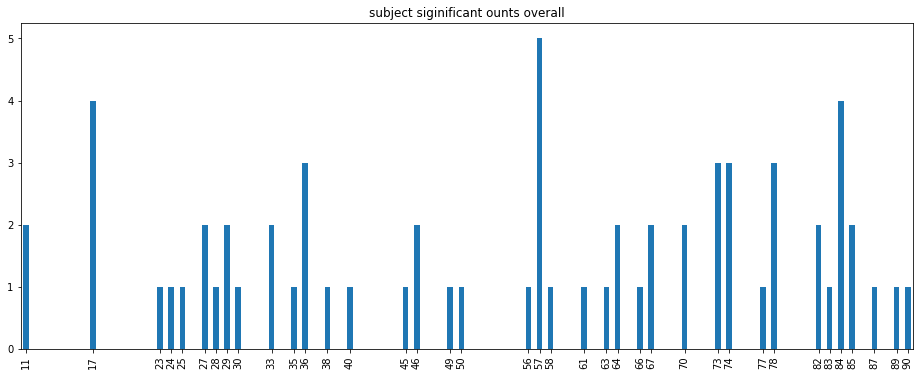

In [73]:
fig=plt.figure(figsize=(16, 6))
prefDF_sig['subSortAF'].value_counts().plot(kind='bar')
plt.title('subject siginificant ounts overall')

Text(0.5, 1.0, 'counts by session')

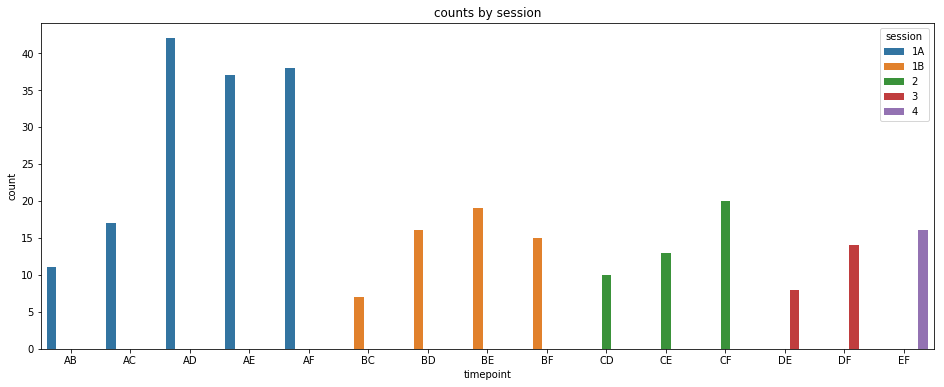

In [20]:
fig=plt.figure(figsize=(16, 6))

sns.countplot('timepoint',hue='session',data=prefDF_sig,order=['AB','AC','AD','AE','AF','BC','BD','BE','BF','CD','CE','CF','DE','DF','EF'],hue_order=['1A','1B','2','3','4'])
plt.title('counts by session')

Text(0.5, 1.0, 'counts by session')

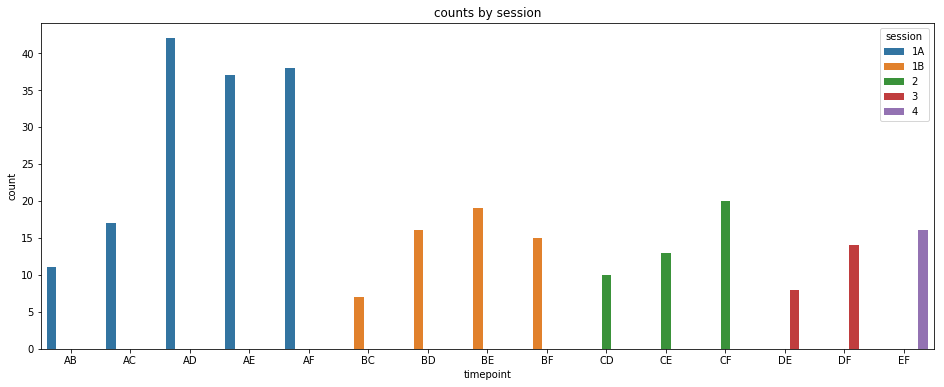

In [78]:
fig=plt.figure(figsize=(16, 6))

sns.countplot('timepoint',hue='session',data=prefDF_sig,order=['AB','AC','AD','AE','AF','BC','BD','BE','BF','CD','CE','CF','DE','DF','EF'],hue_order=['1A','1B','2','3','4'])
plt.title('counts by session')

# Radar Plot

In [32]:
def radarPlotDF(countsdf,title,lg1,lg2,**kwargs):
    """
    makes a radar plot from a dataframe with the first two columns being
    used as 'pre' and 'post

    countssdf: a 2 column dataframe with counts
    15: how to scale

    optional-
    colorcode: put color code or not? 'on' if yes.
    """
    f = plt.figure(figsize=(8,10))

    colorcode=kwargs.get('colorcode',None)
    savefile=kwargs.get('savefile',None)
    version=kwargs.get('version',None)
    
    
    #set up colors
    hues=np.linspace(0,1,15,endpoint=False)
    hues=['%1.2f' % i for i in hues]
    hues=[float(i) for i in hues]
    colors = plt.cm.hsv(hues)
    # Compute pie slices
    N = 15
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    radii = np.repeat(1,N)
    width = np.repeat(0.25,N)

    #set up data
    counts_df1=countsdf.iloc[:,0]
    counts_df2=countsdf.iloc[:,1]
    
    if version=='comp':
        counts_df3=countsdf.iloc[:,2]
        counts_df4=countsdf.iloc[:,3]
        counts_df5=countsdf.iloc[:,4]
        counts_df6=countsdf.iloc[:,5]


    #     categories1=[str(i) for i in counts_df1.index]#cars
#     categories1=['Shirt '+str(i) for i in np.arange(1,16)]
#     categories1=[str(np.round(i,decimals=2)) for i in np.linspace(0,1,15,endpoint=False)]
    categories1=[str(i) for i in np.arange(1,16)]


    N = len(categories1)
    #cars
    values1=[i for i in counts_df1.values]
    values1 += values1[:1] #makes it circular
    values2=[i for i in counts_df2.values]
    values2 += values2[:1] #makes it circular
    
    if version=='comp':
        values3=[i for i in counts_df3.values]
        values3 += values3[:1] #makes it circular

        values4=[i for i in counts_df4.values]
        values4 += values4[:1] #makes it circular

        values5=[i for i in counts_df5.values]
        values5 += values5[:1] #makes it circular

        values6=[i for i in counts_df6.values]
        values6 += values6[:1] #makes it circular
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    #this doesn't change for all. all have 16 data points
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    
    # Initialise the spider plot
    ax = f.add_subplot(111, polar=True)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories1, color='black', size=16)
    
    ax.set_rlabel_position(180)
    # Draw ylabels
    ax.set_rlabel_position(320)
    plt.yticks([i for i in np.arange(0,14)],[],color="black", size=5)
#     plt.yticks([i for i in np.arange(2,15,2)],['2','4','6','8','10','12','14','16'],color="black", size=10)
#     plt.yticks([i for i in np.arange(2,14,2)],[''],color="grey", size=0)

    plt.ylim(0,14)

    ax.plot(angles, values1, linewidth=2, linestyle='solid',color='b')
    ax.plot(angles, values2, linewidth=2, linestyle='solid',color='r')
    
    ax.legend([lg1,lg2],bbox_to_anchor=(-0.2, 0.1))

    
    if version=='comp':
        ax.plot(angles, values3, linewidth=1, linestyle='--',color='r')
        ax.plot(angles, values4, linewidth=1, linestyle='--',color='r')
        ax.plot(angles, values5, linewidth=1, linestyle='--',color='r')
        ax.plot(angles, values6, linewidth=1, linestyle='--',color='r')
        
        ax.fill(angles, values3,'r',alpha=0.05)
        ax.fill(angles, values4,'r',alpha=0.04)
        ax.fill(angles, values5,'r',alpha=0.03)
        ax.fill(angles, values6,'r',alpha=0.02)
        ax.legend(['1A','1B','2','3','4','5'],bbox_to_anchor=(0.1, 0.1))


    # Fill area
    ax.fill(angles, values1,'blue',alpha=0.15)
    ax.fill(angles, values2,'red',alpha=0.15)


    if colorcode=='on':
        bars = ax.bar(theta, radii, width=width, bottom=13.5, color=colors)

    # Add legend
    plt.title(title)
    if savefile=='on':
        plt.savefig(title+'.png', dpi=350, transparent=True)


In [45]:
def plotRadar(objectDict,subSort,category,call,**kwargs):
    """
    makes plotting radar plots easier
    
    objectDict= dictionary with subject objects
    subSort=subSortAF number
    category=shirt/car/phone
    call='Fixed' or Consecutive
    """
    
    savefile=kwargs.get('savefile',None)

    finalSubs=['sub'+str(i) for i in np.concatenate([np.arange(1,84),np.arange(85,97)])]#removed 84 which is random

    AFtoSub=dict(zip([Subs[i].subSortAF for i in finalSubs],
         [Subs[i].newsubnum for i in finalSubs]))
         
    subnum=str(AFtoSub[subSort])#grabbed from below
    print(subnum)
    df=getattr(objectDict['sub'+subnum],'ABCDEF_'+category+'Counts')
    
    #add distance
    fixed_d=[item for sublist in [prefDF[(prefDF['timepoint']==i) & 
       (prefDF['category']=='Shirts') &
      (prefDF['subSortAF']==subSort)].distances.values for i in ['AB','AC','AD','AE','AF']] for item in sublist]
    
    con_d=[item for sublist in [prefDF[(prefDF['timepoint']==i) & 
       (prefDF['category']==category) &
      (prefDF['subSortAF']==subSort)].distances.values for i in ['AB','BC','CD','DE','EF']] for item in sublist]
    
    
    
    if call=='F':
                
        sns.pointplot(['AB','AC','AD','AE','AF'],[i/105 for i in fixed_d])

        radarPlotDF(df.iloc[:,np.r_[0,1]],'sub'+str(subSort)+' --AB'+'_dist_'+str(np.round(fixed_d[0]/105,2)),'pre','20min',colorcode='on',savefile=savefile)
        radarPlotDF(df.iloc[:,np.r_[0,2]],'sub'+str(subSort)+' --AC'+'_dist_'+str(np.round(fixed_d[1]/105,2)),'pre','1wk',colorcode='on',savefile=savefile)
        radarPlotDF(df.iloc[:,np.r_[0,3]],'sub'+str(subSort)+' --AD'+'_dist_'+str(np.round(fixed_d[2]/105,2)),'pre','2wks',colorcode='on',savefile=savefile)
        radarPlotDF(df.iloc[:,np.r_[0,4]],'sub'+str(subSort)+' --AE'+'_dist_'+str(np.round(fixed_d[3]/105,2)),'pre','3wks',colorcode='on',savefile=savefile)
        radarPlotDF(df.iloc[:,np.r_[0,5]],'sub'+str(subSort)+' --AF'+'_dist_'+str(np.round(fixed_d[4]/105,2)),'pre','4wks',colorcode='on',savefile=savefile)
        
    if call=='C':
        sns.pointplot(['AB','BC','CD','DE','EF'],[i/105 for i in con_d])

        radarPlotDF(df.iloc[:,np.r_[0,1]],'sub'+str(subSort)+' --AB'+'_dist_'+str(np.round(con_d[0]/105,2)),'pre','20min',colorcode='on')
        radarPlotDF(df.iloc[:,np.r_[1,2]],'sub'+str(subSort)+' --BC'+'_dist_'+str(np.round(con_d[1]/105,2)),'20min','1wk',colorcode='on')
        radarPlotDF(df.iloc[:,np.r_[2,3]],'sub'+str(subSort)+' --CD'+'_dist_'+str(np.round(con_d[2]/105,2)),'1wk','2wks',colorcode='on')
        radarPlotDF(df.iloc[:,np.r_[3,4]],'sub'+str(subSort)+' --DE'+'_dist_'+str(np.round(con_d[3]/105,2)),'2wks','3wks',colorcode='on')
        radarPlotDF(df.iloc[:,np.r_[4,5]],'sub'+str(subSort)+' --EF'+'_dist_'+str(np.round(con_d[4]/105,2)),'3wks','4wks',colorcode='on')
        

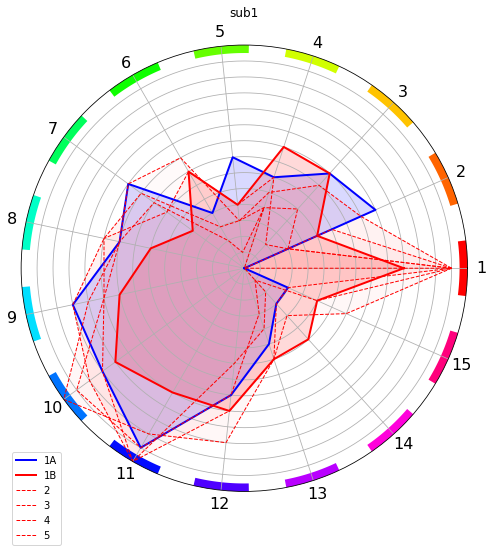

In [47]:
radarPlotDF(Subs['sub60'].ABCDEF_ShirtsCounts,'sub1','pre','post',version='comp',colorcode='on')

Changes from first counts to subsequent sessions

## Comparision of instabilities across three illustrative subjects

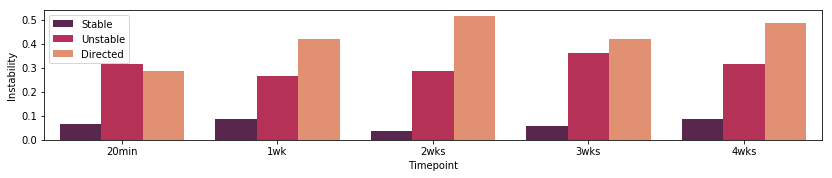

In [14]:
threeBody=[]
for k in [3,56,90]:
    threeBody.append([item for sublist in [prefDF[(prefDF['timepoint']==i) & 
   (prefDF['category']=='Cars') &
  (prefDF['subSortAF']==k)].distances.values for i in ['AB','AC','AD','AE','AF']] for item in sublist])
threeBody=pd.DataFrame(threeBody)
threeBody.columns=['20min','1wk','2wks','3wks','4wks']
threeBody.index=['Stable','Unstable', 'Directed']
threeBody=threeBody.T
threeBody=threeBody.melt()
threeBody['Timepoint']=np.tile(['20min','1wk','2wks','3wks','4wks'],3)
threeBody['value']=threeBody.value/105
threeBody.columns=['Type','Instability','Timepoint']

fig=plt.figure(figsize=(18, 3))
ax=sns.barplot(x='Timepoint',hue='Type',y='Instability',data=threeBody,palette='rocket')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
# plt.savefig('subPoint'+'.png', dpi=500, transparent=True,bbox_inches='tight')


The 'stable' subject did not change their preferences much, whereas the other two subjects changed, the 'unstable' subject was not consistent in how they change, whereas the 'directed' subject was

# Hochberg Correction

need to do a correction for multiple comparisons

In [97]:
foo=prefDF.groupby('subSortAF').get_group(1)

In [98]:
foo['rank']=stats.rankdata(prefDF.groupby('subSortAF').get_group(1)['pval'])

C:\Users\al33m\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
foo=foo.sort_values(by='rank')

In [102]:
len(foo)

45

In [103]:
foo['test']=0.05

In [104]:
foo['hochberg']=(foo['rank']/45)*0.05

In [105]:
foo

,timepoint,session,elapTime,class,choices,distances,Z,pval,subname,category,subSortAF,change,rank,test,hochberg
1849,AF,1A,4wks,Fixed,5,11,2.752715,0.002955,sub47,Shirts,1,No,1.0,0.05,0.001111
1876,AC,1A,1wk,Fixed,2,9,2.457130,0.007003,sub47,Phones,1,No,2.0,0.05,0.002222
1846,AC,1A,1wk,Fixed,2,10,2.214140,0.013410,sub47,Shirts,1,No,3.0,0.05,0.003333
1864,AF,1A,4wks,Fixed,5,8,2.112100,0.017339,sub47,Cars,1,No,4.0,0.05,0.004444
1878,AE,1A,3wks,Fixed,4,8,1.859449,0.031482,sub47,Phones,1,No,5.5,0.05,0.006111
1880,BC,1B,1wk,Consecutive,2,8,1.859449,0.031482,sub47,Phones,1,No,5.5,0.05,0.006111
1862,AD,1A,2wks,Fixed,3,7,1.478470,0.069641,sub47,Cars,1,No,7.5,0.05,0.008333
1873,DF,3,2wks,Misc,5,7,1.478470,0.069641,sub47,Cars,1,No,7.5,0.05,0.008333
1882,BE,1B,3wks,Misc,4,7,1.261769,0.103516,sub47,Phones,1,No,10.0,0.05,0.011111
1879,AF,1A,4wks,Fixed,5,7,1.261769,0.103516,sub47,Phones,1,No,10.0,0.05,0.011111


In [119]:
foo['pval']<foo['hochberg']

1849    False
1876    False
1846    False
1864    False
1878    False
1880    False
1862    False
1873    False
1882    False
1879    False
1875    False
1848    False
1863    False
1845    False
1854    False
1850    False
1847    False
1856    False
1872    False
1871    False
1868    False
1867    False
1861    False
1860    False
1884    False
1858    False
1853    False
1851    False
1865    False
1869    False
1866    False
1852    False
1883    False
1886    False
1887    False
1877    False
1855    False
1870    False
1885    False
1888    False
1881    False
1889    False
1857    False
1859    False
1874    False
dtype: bool

In [114]:
import statsmodels.api as sm

In [116]:
from statsmodels.stats.multitest import multipletests

In [128]:
multipletests(foo['pval'],method='simes-hochberg')

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 array([0.1329825 , 0.30811467, 0.5766113 , 0.72823528, 0.95445541,
        0.95445541, 0.95445541, 0.95445541, 0.95445541, 0.95445541,
        0.95445541, 0.95445541, 0.95445541, 0.95445541, 0.95445541,
        0.95445541, 0.95445541, 0.95445541, 0.95445541, 0.95445541,
        0.95445541, 0.95445541, 0.95445541, 0.95445541, 0.95445541,
        0.95445541, 0.95445541, 0.95445541, 0.95445541, 0.95445541,
        0.95445541, 0.95445541, 0.95445541, 0.95445541, 0.95445541,
        0.95445541, 0.95445541, 0.95445541, 0.95445541, 0.95445541,
        0.95445541, 0.95445541, 0.95445541, 0.95445541, 0.95445541]),
 0.0011392016030112861,
 0.00

In [133]:
class HockTest():
    def __init__(self,subname):
        
        self.df=prefDF.groupby('subSortAF').get_group(subname)
        self.df['corrected']=multipletests(self.df['pval'],method='simes-hochberg')[0]
        self.stats=self.df.groupby('class').agg({'corrected':'sum'})

In [136]:
hockD={}

In [140]:
for i in np.unique(prefDF['subSortAF']):
    print(i)
    hockD[i]=HockTest(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23

C:\Users\al33m\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
56
57
58
60
61
62
63
64
65
66
67
68
69
70
71
73
74
75
76
77
78
79
81
82
83
84
85
86
87
89
90


In [152]:
np.sum(hockD[1].stats,axis=0).values[0]

0

In [164]:
overall=[]
fixed=[]

for i in np.unique(prefDF['subSortAF']):
    overall.append(np.sum(hockD[i].stats,axis=0).values[0])
    fixed.append(hockD[i].stats.loc['Fixed'][0])

In [165]:
85-np.sum([i==0 for i in overall])

76

In [20]:
76/85

0.8941176470588236

In [21]:
59/85

0.6941176470588235

In [166]:
85-np.sum([i==0 for i in fixed])

59